📌 End To End Steps¶

1️⃣ Load & Explore Data – Import Hospital dataset, preprocess, and visualize.

2️⃣ Train-Test Split – Split time series correctly (no shuffling).

3️⃣ Analyze - plot ACF/PACF.

4️⃣ Achieve Stationarity – Apply differencing, ADF test

5️⃣ Baseline Models – Compare with historical mean & last-value models.

6️⃣ Fit AR Model – Select lag order, train AR(p)I(d) MA(q)

7️⃣ Evaluate Performance – Compare with baselines using MAE



In [331]:
# 🔹 Step 1: Import Libraries & Load Data

In [50]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


from scipy.stats import boxcox

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5

In [3]:
df = pd.read_csv('data/hospital.csv')

df.head()

,Unnamed: 0,wait_times_hrs,nurse_count
0,2019-03-04 00:00:00,1.747261,1.0
1,2019-03-04 01:00:00,1.664634,1.0
2,2019-03-04 02:00:00,1.647047,1.0
3,2019-03-04 03:00:00,1.619512,1.0
4,2019-03-04 04:00:00,1.480415,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      168 non-null    object 
 1   wait_times_hrs  168 non-null    float64
 2   nurse_count     168 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.1+ KB


In [5]:
df['date'] = pd.to_datetime(df['Unnamed: 0'])

# Set the date as the index
df.set_index('date', inplace=True)


# Display the dataframe
df.head()

,Unnamed: 0,wait_times_hrs,nurse_count
date,,,
2019-03-04 00:00:00,2019-03-04 00:00:00,1.747261,1.0
2019-03-04 01:00:00,2019-03-04 01:00:00,1.664634,1.0
2019-03-04 02:00:00,2019-03-04 02:00:00,1.647047,1.0
2019-03-04 03:00:00,2019-03-04 03:00:00,1.619512,1.0
2019-03-04 04:00:00,2019-03-04 04:00:00,1.480415,1.0


In [7]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [11]:
df.isna().sum()

wait_times_hrs    0
nurse_count       0
dtype: int64

In [8]:
df.tail()

,wait_times_hrs,nurse_count
date,,
2019-03-10 19:00:00,1.101526,7.0
2019-03-10 20:00:00,1.600607,5.0
2019-03-10 21:00:00,1.709139,5.0
2019-03-10 22:00:00,1.293120,5.0
2019-03-10 23:00:00,1.552522,3.0


In [9]:
df.index.inferred_freq


'h'

In [12]:
df = df.asfreq(df.index.inferred_freq)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2019-03-04 00:00:00 to 2019-03-10 23:00:00
Freq: h
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wait_times_hrs  168 non-null    float64
 1   nurse_count     168 non-null    float64
dtypes: float64(2)
memory usage: 3.9 KB


# 🔹 Step 2: Data Analysis And Visualization

## 📌 Plot the Time Series Data

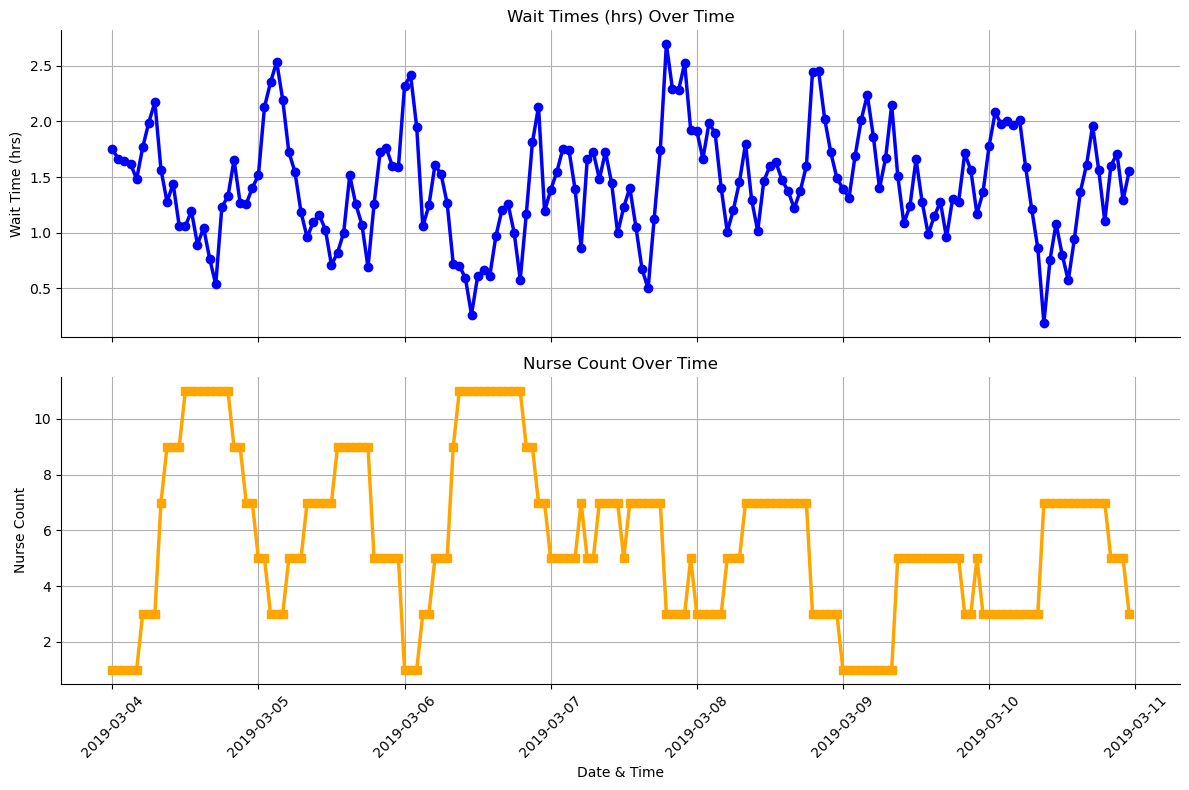

In [46]:
# # Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Plot Wait Times
axes[0].plot(df.index, df['wait_times_hrs'], color='b', marker='o', linestyle='-')
axes[0].set_title("Wait Times (hrs) Over Time")
axes[0].set_ylabel("Wait Time (hrs)")
axes[0].grid(True)

# Plot Nurse Count
axes[1].plot(df.index, df['nurse_count'], color='orange', marker='s', linestyle='-')
axes[1].set_title("Nurse Count Over Time")
axes[1].set_ylabel("Nurse Count")
axes[1].grid(True)

# Formatting
plt.xlabel("Date & Time")
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

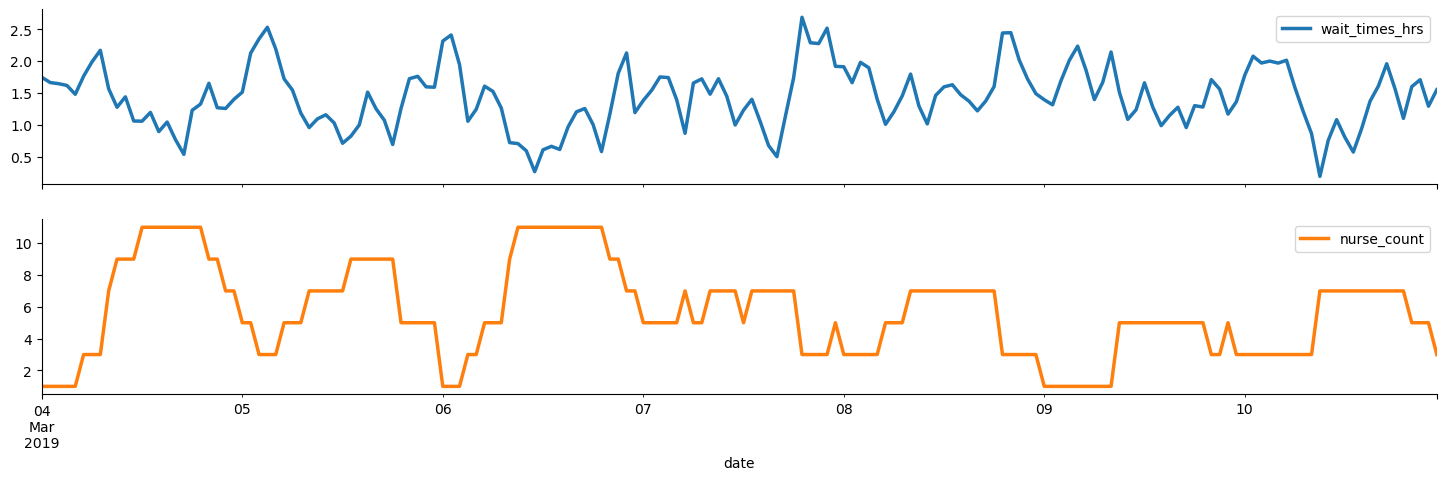

In [21]:
df.plot(subplots=True);

In [37]:
target = df['wait_times_hrs'].to_frame() 
exog = df[['nurse_count']]

## Decompose To Analyse Trend and Seasonality

In [24]:
# decomposition = STL(df['wait_times_hrs'], period=4).fit()

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

# ax1.plot(decomposition.observed)
# ax1.set_ylabel('Observed')

# ax2.plot(decomposition.trend)
# ax2.set_ylabel('Trend')

# ax3.plot(decomposition.seasonal)
# ax3.set_ylabel('Seasonal')

# ax4.plot(decomposition.resid)
# ax4.set_ylabel('Residuals')

# # plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

# fig.autofmt_xdate()
# plt.tight_layout()

## Check for Stationarity - Dickey-Fuller Test

In [28]:
# ADF Test
def adf_test(series, alpha=0.05):
    """
    Performs the Augmented Dickey-Fuller (ADF) test on a time series.

    Parameters:
    - series (pd.Series): The time series data to test.
    - alpha (float): Significance level (default is 0.05).

    Returns:
    - None (prints the results)
    """
    result = adfuller(series, autolag='AIC')

    # Create results dictionary
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '# Lags Used': result[2],
        'Number of Observations': result[3],
    }

    # Add critical values
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Convert to DataFrame for better readability
    output_df = pd.DataFrame(output.items(), columns=['Metric', 'Value'])

    # Print the results
    print("\n🔍 Results of Augmented Dickey-Fuller Test:")
    print(output_df.to_string(index=False))

    # Interpretation
    print("\n📌 Interpretation:")
    if result[1] <= alpha:
        print(f"✅ The time series is **stationary** (p-value = {result[1]:.5f} ≤ {alpha})")
    else:
        print(f"❌ The time series is **not stationary** (p-value = {result[1]:.5f} > {alpha})")

In [31]:
adf_test(target)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric      Value
        Test Statistic  -5.010240
               p-value   0.000021
           # Lags Used   5.000000
Number of Observations 162.000000
   Critical Value (1%)  -3.471374
   Critical Value (5%)  -2.879552
  Critical Value (10%)  -2.576373

📌 Interpretation:
✅ The time series is **stationary** (p-value = 0.00002 ≤ 0.05)


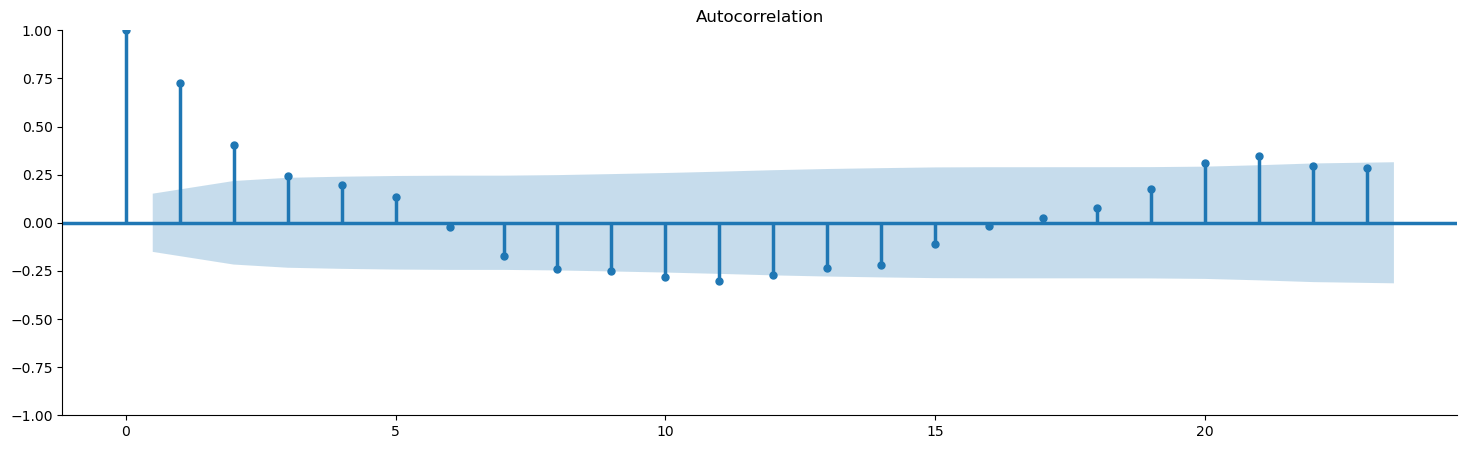

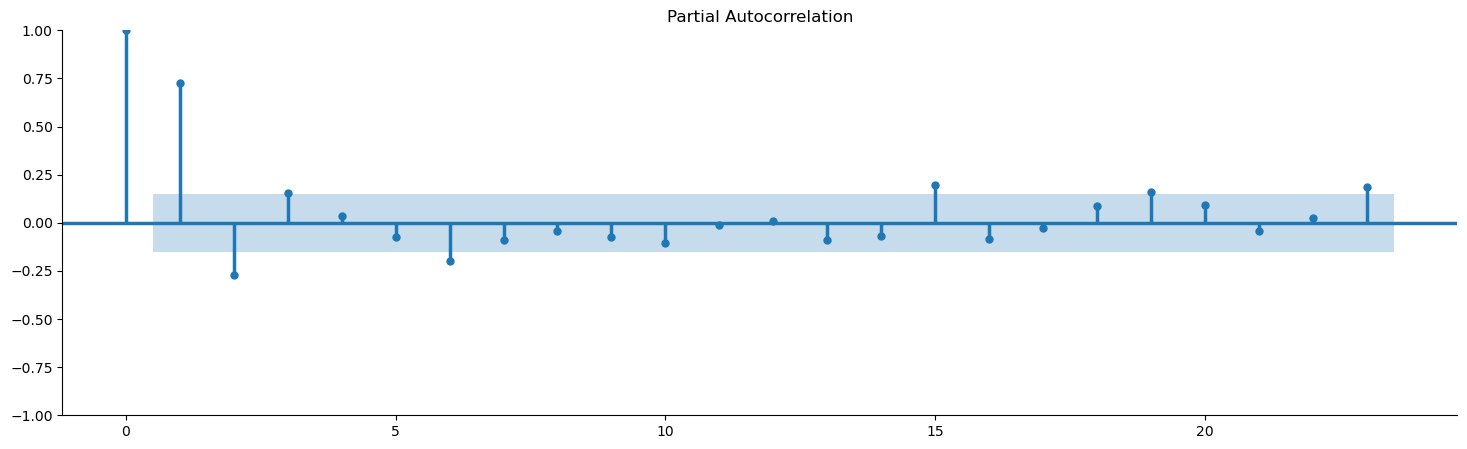

In [32]:
# plot_acf(target)
# plot_pacf(target)
# plt.show()

# 🔹 Step 3: Train-Test Split

In [38]:

# train_size = int(len(df) * 0.9)  # 90% training, 10% testing
# train, test = df.iloc[:train_size], df.iloc[train_size:]

target_train = target[:150]
exog_train = exog[:150] 


target_test = target[150:]
exog_test = exog[150:] 

In [342]:
# print(f"Training Size: {len(train)} years")
# print(f"Test Size: {len(test)} years")

Training Size: 75 years
Test Size: 9 years


In [35]:
target_train.head()

,wait_times_hrs
date,
2019-03-04 00:00:00,1.747261
2019-03-04 01:00:00,1.664634
2019-03-04 02:00:00,1.647047
2019-03-04 03:00:00,1.619512
2019-03-04 04:00:00,1.480415


In [39]:
exog_train.head()

,nurse_count
date,
2019-03-04 00:00:00,1.0
2019-03-04 01:00:00,1.0
2019-03-04 02:00:00,1.0
2019-03-04 03:00:00,1.0
2019-03-04 04:00:00,1.0


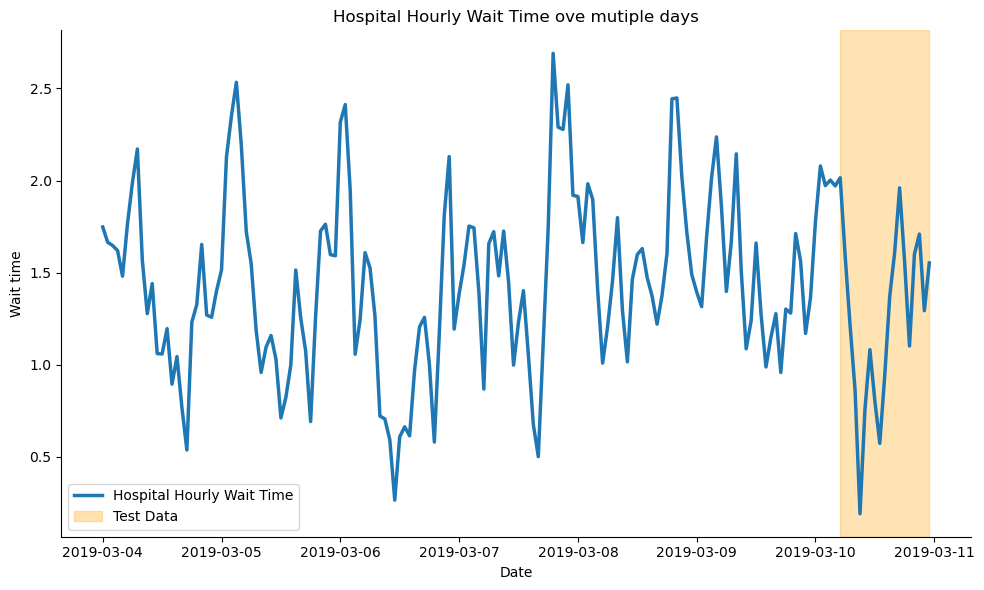

In [41]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['wait_times_hrs'], label='Hospital Hourly Wait Time')

# Highlight the period corresponding to the test data
plt.axvspan(target_train.index[-1], df.index[-1], color='orange', alpha=0.3, label='Test Data')

# Add labels, title, and show legend
plt.xlabel('Date')
plt.ylabel('Wait time')
plt.title('Hospital Hourly Wait Time ove mutiple days')
plt.legend()

plt.tight_layout()
plt.show()

# 🔹 Step 4:Create ARMAX Model

## Determine Lag Order (p,q,d=2)

### AIC Criteria for best order selection

In [361]:
# from tqdm import tqdm
# import pandas as pd
# from itertools import product
# from statsmodels.tsa.arima.model import ARIMA

# def optimize_arima(endog, order_list, d):
#     results = []
    
#     for order in tqdm(order_list, desc="Optimizing ARIMA models"):
#         try:
#             # Fit ARIMA model
#             model = ARIMA(
#                 endog, 
#                 order=(order[0], d, order[1])
#             ).fit()
#         except Exception as e:
#             print(f"Model {order} failed with error: {e}")
#             continue
        
#         # Collect AIC for the model
#         aic = model.aic
#         results.append([order, aic])
        
#     # If no valid models were found
#     if not results:
#         print("No valid models were found.")
#         return pd.DataFrame()
    
#     # Create a DataFrame with results
#     result_df = pd.DataFrame(results, columns=['(p, q)', 'AIC'])
    
#     # Sort in ascending order based on AIC
#     result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
#     return result_df


In [47]:
from itertools import product
import pandas as pd


p_range = range(0, 4, 1)
d = 0
q_range = range(0, 4, 1)
P_range = range(0, 4, 1)
D = 0
Q_range = range(0, 4, 1)
s = 24

parameters = product(p_range, q_range, P_range, Q_range)
parameters_list = list(parameters)
print(parameters_list)

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 1, 3), (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (0, 0, 2, 3), (0, 0, 3, 0), (0, 0, 3, 1), (0, 0, 3, 2), (0, 0, 3, 3), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 0, 2), (0, 1, 0, 3), (0, 1, 1, 0), (0, 1, 1, 1), (0, 1, 1, 2), (0, 1, 1, 3), (0, 1, 2, 0), (0, 1, 2, 1), (0, 1, 2, 2), (0, 1, 2, 3), (0, 1, 3, 0), (0, 1, 3, 1), (0, 1, 3, 2), (0, 1, 3, 3), (0, 2, 0, 0), (0, 2, 0, 1), (0, 2, 0, 2), (0, 2, 0, 3), (0, 2, 1, 0), (0, 2, 1, 1), (0, 2, 1, 2), (0, 2, 1, 3), (0, 2, 2, 0), (0, 2, 2, 1), (0, 2, 2, 2), (0, 2, 2, 3), (0, 2, 3, 0), (0, 2, 3, 1), (0, 2, 3, 2), (0, 2, 3, 3), (0, 3, 0, 0), (0, 3, 0, 1), (0, 3, 0, 2), (0, 3, 0, 3), (0, 3, 1, 0), (0, 3, 1, 1), (0, 3, 1, 2), (0, 3, 1, 3), (0, 3, 2, 0), (0, 3, 2, 1), (0, 3, 2, 2), (0, 3, 2, 3), (0, 3, 3, 0), (0, 3, 3, 1), (0, 3, 3, 2), (0, 3, 3, 3), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 0, 2), (1, 0, 0, 3), (1, 0, 1, 0), (1, 0, 1, 1), (1, 0, 1, 2), (1, 0

In [48]:
from pmdarima import auto_arima

# Fit the SARIMA model using auto_arima with exogenous variables
model = auto_arima(
    target_train,  # Endogenous variable (target)
    exogenous=exog_train,  # Exogenous variables (if any)
    d=d,
    D=D,
    seasonal=True,
    m=s,  # Periodicity of the seasonality (e.g., 12 for monthly data with yearly seasonality)
    p=p_range,  # List of possible p values
    q=q_range,  # List of possible q values
    P=P_range,  # List of possible P values
    Q=Q_range,  # List of possible Q values
    stepwise=True,  # Stepwise optimization for hyperparameter selection
    trace=True,  # Print progress during the optimization process
    error_action='ignore',  # Ignore any errors during model fitting
    suppress_warnings=True  # Suppress warnings
)

# Get the best model and its parameters
best_order = model.order  # (p, d, q)
best_seasonal_order = model.seasonal_order  # (P, D, Q, s)
best_aic = model.aic()

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    '(p, q, P, Q)': [best_order + best_seasonal_order[:3]],
    'AIC': [best_aic]
})

result_df

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=89.296, Time=2.71 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=208.339, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=92.978, Time=0.81 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=104.483, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=556.534, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=84.471, Time=1.96 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=87.612, Time=0.56 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=86.278, Time=5.92 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=84.987, Time=1.96 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=88.286, Time=8.15 sec
 ARIMA(1,0,2)(0,0,1)[24] intercept   : AIC=82.477, Time=1.29 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=85.690, Time=0.38 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=87.205, Time=1.87 sec
 ARIMA(1,0,2)(0,0,2)[24] intercept   : AIC=84.284, Time=2.45 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=8

,"(p, q, P, Q)",AIC
0,"(1, 0, 1, 0, 0, 1)",81.239985


## Train SARIMAX Model

In [51]:
best_model = SARIMAX(target_train, exog_train, order=(1,0,1), seasonal_order=(0,0,1,12), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     wait_times_hrs   No. Observations:                  150
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                 -33.508
Date:                            Mon, 17 Feb 2025   AIC                             77.016
Time:                                    09:07:23   BIC                             92.070
Sample:                                03-04-2019   HQIC                            83.132
                                     - 03-10-2019                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
nurse_count    -0.1338      0.021     -6.487      0.000      -0.174      -0.093
ar.L1           0.9838      0.01

In [364]:
# model = ARIMA(train, order=(3,2,3))
# model_fit = model.fit()
# residuals = model_fit.resid

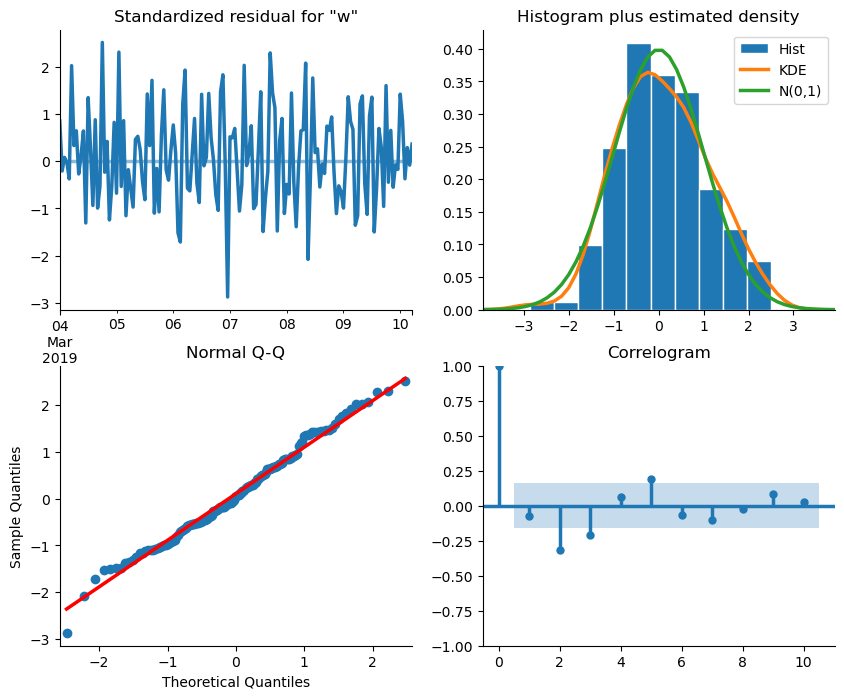

In [53]:
best_model_fit.plot_diagnostics(figsize=(10,8));


# 🔹 Step 6: Model Evaluation
.

## 🔹 Evaluate Model on Test Data

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2019-03-04 00:00:00 to 2019-03-10 23:00:00
Freq: h
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wait_times_hrs  168 non-null    float64
 1   nurse_count     168 non-null    float64
dtypes: float64(2)
memory usage: 3.9 KB


In [56]:
target_test

,wait_times_hrs
date,
2019-03-10 06:00:00,1.589435
2019-03-10 07:00:00,1.211038
2019-03-10 08:00:00,0.861520
2019-03-10 09:00:00,0.190557
2019-03-10 10:00:00,0.756846
2019-03-10 11:00:00,1.081632
2019-03-10 12:00:00,0.802831
2019-03-10 13:00:00,0.572779
2019-03-10 14:00:00,0.942950


In [60]:
forecast_test = best_model_fit.get_prediction(start=len(target_train), end=len(target_train)+len(target_test)-1,dynamic=False, exog=exog_test)


In [62]:
forecast_mean_test=forecast_test.predicted_mean.to_frame()

# Manually assign test index
forecast_mean_test.index = target_test.index  # Ensure it matches the test set
forecast_mean_test

,predicted_mean
date,
2019-03-10 06:00:00,2.032725
2019-03-10 07:00:00,1.992602
2019-03-10 08:00:00,1.965185
2019-03-10 09:00:00,1.383485
2019-03-10 10:00:00,1.341201
2019-03-10 11:00:00,1.300164
2019-03-10 12:00:00,1.293111
2019-03-10 13:00:00,1.282643
2019-03-10 14:00:00,1.243372


In [63]:
confidence_intervals_test=forecast_test.conf_int()


confidence_intervals_test.index = target_test.index  # Ensure it matches the test set
confidence_intervals_test

,lower wait_times_hrs,upper wait_times_hrs
date,,
2019-03-10 06:00:00,1.447890,2.617560
2019-03-10 07:00:00,1.059617,2.925587
2019-03-10 08:00:00,0.789644,3.140726
2019-03-10 09:00:00,0.013491,2.753479
2019-03-10 10:00:00,-0.193711,2.876112
2019-03-10 11:00:00,-0.379007,2.979335
2019-03-10 12:00:00,-0.514752,3.100973
2019-03-10 13:00:00,-0.641593,3.206880
2019-03-10 14:00:00,-0.787155,3.273899


In [64]:
df.head()

,wait_times_hrs,nurse_count
date,,
2019-03-04 00:00:00,1.747261,1.0
2019-03-04 01:00:00,1.664634,1.0
2019-03-04 02:00:00,1.647047,1.0
2019-03-04 03:00:00,1.619512,1.0
2019-03-04 04:00:00,1.480415,1.0


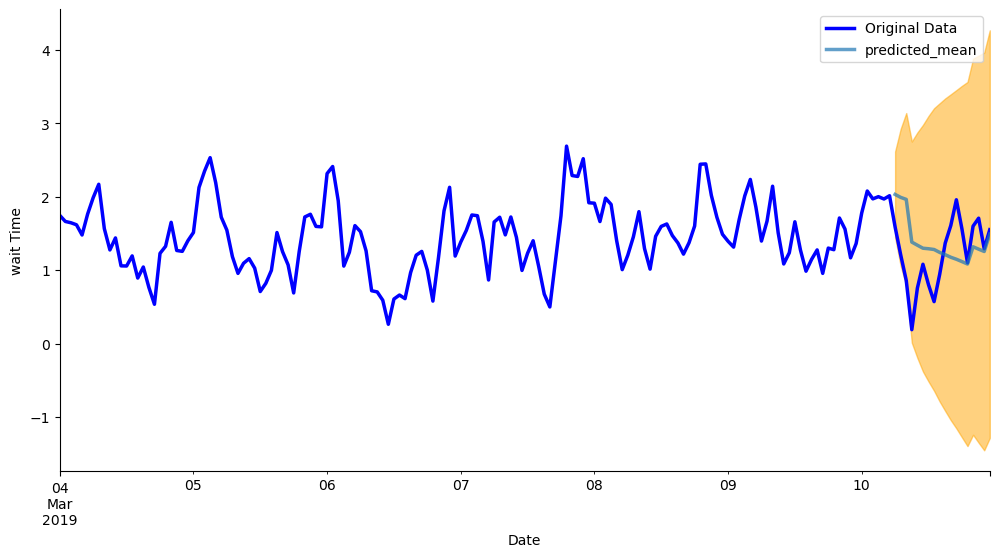

In [69]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# 1️⃣ Plot the full original series
df['wait_times_hrs'].plot(ax=ax, label="Original Data", color="blue")


forecast_mean_test.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7)
ax.fill_between(confidence_intervals_test.index, confidence_intervals_test.iloc[:, 0], confidence_intervals_test.iloc[:, 1], color='orange', alpha=.5)

ax.set_xlabel('Date')
ax.set_ylabel('wait Time')
plt.legend(loc='best')
plt.show()


In [70]:
# Calculate test error
mae_os_test = mean_absolute_error(target_test['wait_times_hrs'], forecast_mean_test)
print(f"Test Data (Dynamic) MAE: {mae_os_test:.3f}")


Test Data (Dynamic) MAE: 0.471
